# Fig 5: Assessing biopsychosocial synergy in prognosis of pain-associated conditions

### This notebook contains the analyses code for figure 5:
- Calculate pooled risk scores for three primary biological modalities (blood, brain, and bone) and the psychosocial modality
- Validate sustained performance of pooled risk scores in pain conditions from which they are derived
- Calculate association of pooled risk scores in the number of pain sites expressed within each condition
-  
- Calculate odds of diagnoses 


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.stats import zscore
from scipy import stats
import warnings

# This will ignore all warnings
warnings.simplefilter(action='ignore', category=Warning)

fs = 6.5
w = 0.5
sns.set_context(rc={"font.size":fs})   
plt.rcParams['font.size'] = fs
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['figure.dpi'] = 300
plt.rc('mathtext',**{'default':'regular'})
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5
plt.rcParams['xtick.major.pad'] = '1.5'
plt.rcParams['ytick.major.pad'] = '1.5'
plt.rcParams['xtick.major.width'] = w
plt.rcParams['ytick.major.width'] = w
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['xtick.minor.pad'] = '1.5'
plt.rcParams['ytick.minor.pad'] = '1.5'
plt.rcParams['xtick.minor.width'] = w
plt.rcParams['ytick.minor.width'] = w
plt.rcParams['axes.linewidth'] = w
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f']

# Pastel2
color_mapping = {
 'Blood': '#9EB9F3',
 'Bone': '#F89C74',
 'PRS': '#DCB0F2',
 'Stacked': '#87C55F',
 'Psychosocial': '#C0BFC9'}

In [13]:
nci_cols_t0 = [
                    'NCI_fibromyalgia_T0',
                    'NCI_polymyalgia rheumatica_T0',
                    'NCI_cervical spondylosis_T0',
                    'NCI_joint pain_T0',
                    'NCI_back pain_T0',
                    'NCI_spine arthritis/spondylitis_T0',
                    'NCI_trapped nerve/compressed nerve_T0',
                    'NCI_sciatica_T0',
                    'NCI_hernia_T0',
                    'NCI_irritable bowel syndrome_T0',
                    'NCI_gastro-oesophageal reflux (gord) / gastric reflux_T0',
                    'NCI_arthritis (nos)_T0',
                    'NCI_osteoarthritis_T0',
                    'NCI_osteoporosis_T0',
                    'NCI_rheumatoid arthritis_T0',
                    'NCI_migraine_T0',
                    'NCI_headaches (not migraine)_T0',
                    'NCI_carpal tunnel syndrome_T0',
                    'NCI_angina_T0',
                    'NCI_endometriosis_T0',
                    'NCI_gout_T0',
                    'NCI_chronic fatigue syndrome_T0',
                    'NCI_ankylosing spondylitis_T0',
                    'NCI_trigemminal neuralgia_T0',
                    'NCI_crohns disease_T0',
                    'NCI_spinal stenosis_T0',
                    'NCI_peripheral neuropathy_T0',
                    'NCI_ulcerative colitis_T0',
                    'NCI_pulmonary embolism +/- dvt_T0',
                    'NCI_chronic obstructive airways disease/copd_T0',
                    'NCI_stroke_T0',
                    'NCI_multiple sclerosis_T0',
                    'NCI_psoriatic arthropathy_T0',
                    'NCI_Post Surgical Pain_T0',
                    # 'NCI_parkinsons disease_T0',
                    'NCI_disc disorder_T0',
                	# 'NCI_peripheral vascular disease_T0'
]
nci_cols_t2 = [i.replace('T0','T2') for i in nci_cols_t0]

rename = {
    'joint pain': 'Joint pain',
 'spinal stenosis': 'Spinal stenosis',
 'trapped nerve/compressed nerve': 'Trapped nerve',
 'stroke': 'stroke',
 'multiple sclerosis': 'Multiple sclerosis',
 'chronic obstructive airways disease/copd': 'COPD',
 'sciatica': 'Sciatica',
 'back pain': 'Back pain',
 'osteoporosis': 'Osteoporosis',
 'spine arthritis/spondylitis': 'Spine arthritis',
 'peripheral neuropathy': 'Peripheral neuropathy',
 'angina': 'Angina',
 'migraine': 'Migraine',
 'hernia': 'Hernia',
 'gout': 'Gout',
 'gastro-oesophageal reflux (gord) / gastric reflux': 'Gastric teflux',
 'arthritis (nos)': 'Arthritis',
 'endometriosis': 'Endometriosis',
 'cervical spondylosis': 'Cervical spondylosis',
 'irritable bowel syndrome': 'IBS',
 'headaches (not migraine)': 'Non-migraine headache',
 'chronic fatigue syndrome': 'Chronic fatigue synd.',
 'polymyalgia rheumatica': 'Polymyalgia rheumatica',
 'ulcerative colitis': 'Ulcerative colitis',
 'psoriasis': 'Psoriasis',
 'osteoarthritis': 'Osteoarthritis',
 'diverticular disease/diverticulitis': 'Diverticulitis',
 'rheumatoid arthritis': 'Rheumatoid arthritis',
 'carpal tunnel syndrome': 'Carpal tunnel synd.',
 'disc disorder': 'Disc disorder',
 'pulmonary embolism +/- dvt': 'Pulmonary embolism',
 'ankylosing spondylitis': 'Ankylosing spondylitis',
 'fibromyalgia': 'Fibromyalgia',
 'trigemminal neuralgia': 'Trigemminal neuralgia',
 'crohns disease': 'Crohns disease',
 'parkinsons disease': 'Parkinsons disease',
 'multiple sclerosis': 'Multiple sclerosis',
 'psoriatic arthropathy': 'Psoriatic arthropathy',
 'Post Surgical Pain': 'Post surgical pain',
 'peripheral vascular disease': 'Peripheral vasc. disease',
 'ChronicWidespreadPain': 'Chronic Widespread Pain',
 'Free': 'Diagnosis-free'
         }

In [3]:
# Load in machine learning model performances
diag_T0 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/first_occ/T0_diagnoses_clf-LR_lin.pickle')
diag_T0 = {key: value for key, value in diag_T0.items() if 'parkinson' not in key}
diag_T0 = {key: value for key, value in diag_T0.items() if 'peripheral vascular disease' not in key}

diag_T2 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/first_occ/T2_diagnoses_clf-LR_lin.pickle')
diag_T2 = {key: value for key, value in diag_T2.items() if 'parkinson' not in key}
diag_T2 = {key: value for key, value in diag_T2.items() if 'peripheral vascular disease' not in key}

# WS = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Diagnoses/Nociplastic/WS_vs_NCI_clf-LR_lin.pickle')
# diag_T2.update(WS)

### Functions for later use

In [4]:
from scipy.stats import ttest_ind

def cohens_d_and_pvalue(series1, series2):
    """
    Compute Cohen's d and p-value.

    Args:
        series1 (pd.Series): Pandas Series 1
        series2 (pd.Series): Pandas Series 2

    Returns:
        float, float: Cohen's d, p-value
    """
    # calculate the mean of each series
    mean1, mean2 = series1.mean(), series2.mean()

    # calculate the variance of each series
    var1, var2 = series1.var(), series2.var()

    # number of observations in each series
    n1, n2 = len(series1), len(series2)

    # calculate the pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # calculate Cohen's d
    d = (mean1 - mean2) / pooled_std

    # compute the t-statistic and p-value
    t_stat, p_value = ttest_ind(series1, series2)

    return d, p_value


ncis = [i.split('_')[1] for i in nci_cols_t2]

modalities = ['T1','DWI','fMRI','Bone']

cohens_d_df = pd.DataFrame(index=ncis, columns=modalities)
p_values_df = pd.DataFrame(index=ncis, columns=modalities)  # dataframe for storing p-values

for nci in ncis:

    for modality in modalities:
        df = pd.concat([pd.DataFrame(diag_T2[i]['roc_curve'],index=['eid',nci,'Prob']).T for i in diag_T2 if f'{nci}_{modality}' in i]).reset_index(drop=True)
        
        case = df[(df[f'{nci}'] == 1)]['Prob']
        control = df[(df[f'{nci}'] == 0)]['Prob']
        cohend, p_value = cohens_d_and_pvalue(case,control)  # get both cohens d and p-value

        # Store the values in the dataframes
        cohens_d_df.loc[nci, modality] = cohend
        p_values_df.loc[nci, modality] = p_value  # store the p-value


In [5]:
def pivot_pickle(df,cols):
    
    T0_cat = pd.concat([df[i]['results_df'] for i in df.keys()])
    T0_cat.index = [i[:-4] for i in T0_cat.index]
    T0_auc = T0_cat.groupby(level=0).mean().AUC_test
    # T0_auc = T0_auc[~T0_auc.index.str.contains('Sparse')]
    ind = np.unique([i.split('_')[1:-1][0] for i in T0_auc.index])
    df = pd.concat([T0_auc[T0_auc.index.str.contains(i)].reset_index(drop=True) for i in cols],axis=1)
    df.index = ind
    df.columns = cols
    
    return df

T0_auc = pivot_pickle(diag_T0,cols=['Blood','PRS','Psychosocial'])
T2_auc = pivot_pickle(diag_T2,cols=['T1','DWI','fMRI','Stacked','Bone'])
merged_auc = pd.concat([T0_auc,T2_auc],axis=1).reindex([i.split('_')[1:-1][0] for i in nci_cols_t0])


# Marker Signature

In [6]:
fmri_cols = diag_T2['NCI_fibromyalgia_fMRI_Iter-0_Fold-0']['weights'][0].index
t1_cols = diag_T2['NCI_fibromyalgia_T1_Iter-0_Fold-0']['weights'][0].index
dwi_cols = diag_T2['NCI_fibromyalgia_DWI_Iter-0_Fold-0']['weights'][0].index
stacked_cols = diag_T2['NCI_fibromyalgia_Stacked_Iter-0_Fold-0']['weights'][0].index
blood_cols = diag_T0['NCI_fibromyalgia_Blood_Iter-0_Fold-0']['weights'][0].index

In [7]:
home_dir = '/Users/Patty/Desktop/EVP_lab/'

cols = ['eid', 
        # T0
        'ChronicPain_T0',
        'ChronicWidespreadPain_T0', 
        'ChronicHeadaches_T0',
        'ChronicNeckShoulderPain_T0', 
        'ChronicHipPain_T0', 
        'ChronicBackPain_T0', 
        'ChronicStomachAbdominalPain_T0', 
        'ChronicKneePain_T0',
        'ChronicFacialPain_T0', 
        'NumberChronicPainTypes_T0',
        # T1
        'ChronicWidespreadPain_T1', 
        'NumberChronicPainTypes_T1',
        # T2
        'ChronicPain_T2',
        'ChronicWidespreadPain_T2', 
        'ChronicHeadaches_T2',
        'ChronicNeckShoulderPain_T2', 
        'ChronicHipPain_T2', 
        'ChronicBackPain_T2', 
        'ChronicStomachAbdominalPain_T2', 
        'ChronicKneePain_T2',
        'ChronicFacialPain_T2', 
        'NumberChronicPainTypes_T2',
        'NumberReportedNonCancer_T0',
        'NumberReportedNonCancer_T1',
        'NumberReportedNonCancer_T2',
       # Impact
        'OverallHealthRating_T0',
        'UnableWorkDueSicknessDisability_T0',
        'OverallHealthRating_T2',
        'UnableWorkDueSicknessDisability_T2',
       # Additional
       'Age_T0',
        'Age_T1',
       'Age_T2',
       'Sex_T0']
UKB = pd.read_csv(home_dir + 'UKB_NoBrain_500K_V4.csv',low_memory=False,usecols=cols) #UKB demographic data
UKB = UKB.drop(columns=UKB.filter(like='T0').columns[113:172])
UKB.loc[UKB['ChronicWidespreadPain_T0'] == 1, 'NumberChronicPainTypes_T0'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T0'] > 4, 'NumberChronicPainTypes_T0'] = 4
UKB.loc[UKB['ChronicWidespreadPain_T1'] == 1, 'NumberChronicPainTypes_T1'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T1'] > 4, 'NumberChronicPainTypes_T1'] = 4
UKB.loc[UKB['ChronicWidespreadPain_T2'] == 1, 'NumberChronicPainTypes_T2'] = 7
UKB.loc[UKB['NumberChronicPainTypes_T2'] > 4, 'NumberChronicPainTypes_T2'] = 4

# NCI Data
NCI = pd.read_csv(home_dir + 'NCI_combined.csv')

#Only take UKB eids in brain eids
UKB = UKB.merge(NCI,on='eid')

UKB['NCI_Free_T0'] = np.where(UKB.NCI_T0 == 0,1,0)
UKB['NCI_Free_T1'] = np.where(UKB.NCI_T1 == 0,1,0)
UKB['NCI_Free_T2'] = np.where(UKB.NCI_T2 == 0,1,0)
UKB['NCI_Free_T3'] = np.where(UKB.NCI_T3 == 0,1,0)


In [8]:
# Extract unique disease names from one of the lists
disease_names = [col.replace("_T0", "") for col in nci_cols_t0]

# Define the pairs of timepoints to compare
timepoint_pairs = [('T0', 'T1'), ('T0', 'T2'), ('T2', 'T3')]

for disease in disease_names:
    for tp1, tp2 in timepoint_pairs:
        # Developed disease between tp1 and tp2
        developed_col = f'{disease}_developed_{tp1}_to_{tp2}'
        UKB[developed_col] = ((UKB[f'{disease}_{tp1}'] == 0) & (UKB[f'{disease}_{tp2}'] == 1)).astype(int)
        
        # Maintained disease between tp1 and tp2
        maintained_col = f'{disease}_maintained_{tp1}_to_{tp2}'
        UKB[maintained_col] = ((UKB[f'{disease}_{tp1}'] == 1) & (UKB[f'{disease}_{tp2}'] == 1)).astype(int)
        
        # Healthy at both timepoints
        healthy_col = f'healthy_{tp1}_and_{tp2}'
        UKB[healthy_col] = ((UKB[f'NCI_Free_{tp1}'] == 1) & (UKB[f'NCI_Free_{tp2}'] == 1)).astype(int)

# Pain Prevalence Across Risk Quintiles

In [9]:
# Function to extract predicted probabilities from models
def merge_dataframe(dic, nci, mod1, mod2):
    a_data = [pd.DataFrame(dic[i]['roc_curve'].T, columns=['eid',f'y_true_{mod1}',f'{nci}_{mod1}']) for i in dic.keys() if f'{nci}_{mod1}' in i]
    a_data_o = pd.concat([pd.DataFrame(dic[i]['roc_curve_other'].T, columns=['eid',f'y_true_{mod1}',f'{nci}_{mod1}']) for i in dic.keys() if f'{nci}_{mod1}' in i])
    a = pd.concat([pd.concat(a_data),a_data_o]).groupby('eid').mean()
    a.columns = ['Dx',mod1]
    
    b_data = [pd.DataFrame(dic[i]['roc_curve'].T, columns=['eid',f'y_true_{mod2}',f'{nci}_Psychosocial']) for i in dic.keys() if f'{nci}_{mod2}' in i]
    b_data_o = pd.concat([pd.DataFrame(dic[i]['roc_curve_other'].T, columns=['eid',f'y_true_{mod2}',f'{nci}_{mod2}']) for i in dic.keys() if f'{nci}_{mod2}' in i])
    b = pd.concat([pd.concat(b_data),b_data_o]).groupby('eid').mean()
    b.columns = ['Dx',mod2]
    b = b.drop(columns='Dx')

    merged_df = a.merge(b, on='eid')
    # merged_df[mod1] = np.log(merged_df[mod1] / (1 - merged_df[mod1]))
    # merged_df[mod2] = np.log(merged_df[mod2] / (1 - merged_df[mod2]))
    # merged_df.columns = [nci,nci+'_'+mod1,nci+'_'+mod2] # Adds individual dx name to columns

    return merged_df


## Calculate pooled risk scores for top diseases from blood, brain, and bone modalities and their time-locked psychosocial modalities


In [10]:
def create_pivot_heatmap(merged_auc, dic, UKB, mod, T, strata, n):
    
    # Extract the top n indices based on the specified modality
    
    # if mod == 'Stacked':
    if mod == 'TMP':
        n = ['fibromyalgia', 'chronic fatigue syndrome', 'ChronicWidespreadPain']
    else:
        n = merged_auc.sort_values(mod, ascending=False).index[:n]
    print(n)
    
    combined_df = pd.DataFrame()
    ncis = []
    for nci in n:
        tmp = merge_dataframe(dic, nci, mod, 'Psychosocial')
        combined_df = pd.concat([combined_df, tmp])
        if nci == 'ChronicWidespreadPain':
            ncis.append(f'{nci}_{T}')
        else:
            ncis.append(f'NCI_{nci}_{T}')
        
    combined_df = combined_df.groupby('eid').mean()
    combined_df['Dx'] = np.where(combined_df['Dx'] > 0, 1, 0)
    
    df = UKB[['eid', f'NCI_{T}', f'ChronicPain_{T}', f'NumberChronicPainTypes_{T}'] + ncis].merge(combined_df, on='eid')
    df_dx = df[(df['Dx'] == 1) | (df[f'NCI_{T}'] == 0)] # Include healthy
    
    df_dx['bio_strata'] = pd.qcut(df_dx[mod], q=strata, labels=False)
    df_dx['psycho_strata'] = pd.qcut(df_dx['Psychosocial'], q=strata, labels=False)
    df_dx['Bio'] = df_dx[mod]
    df_dx['Psycho'] = df_dx['Psychosocial']
    df_dx['Bio'] = np.log(df_dx[mod] / (1 - df_dx[mod]))
    df_dx['Psycho'] = np.log(df_dx['Psychosocial'] / (1 - df_dx['Psychosocial']))
    
    df_dx
    return df_dx

# Blood at T0
TP = 'T0'
combined_sigs_blood = create_pivot_heatmap(merged_auc, diag_T0, UKB, 'Blood', TP, 5, 13).dropna()

# Brain and Bone at T2
TP = 'T2'
combined_sigs_bone = create_pivot_heatmap(merged_auc, diag_T2, UKB, 'Bone', TP, 5, 4).dropna()
combined_sigs_brain = create_pivot_heatmap(merged_auc, diag_T2, UKB, 'Stacked', TP, 5, 5).dropna()

Index(['gout', 'polymyalgia rheumatica', 'stroke', 'rheumatoid arthritis',
       'crohns disease', 'angina', 'psoriatic arthropathy',
       'peripheral neuropathy', 'ankylosing spondylitis',
       'carpal tunnel syndrome', 'pulmonary embolism +/- dvt',
       'ulcerative colitis', 'arthritis (nos)'],
      dtype='object')
Index(['osteoporosis', 'gout', 'spinal stenosis', 'carpal tunnel syndrome'], dtype='object')
Index(['multiple sclerosis', 'stroke', 'fibromyalgia',
       'chronic fatigue syndrome', 'cervical spondylosis'],
      dtype='object')


## Plot pooled risk score effect size for each condition composing the risk score

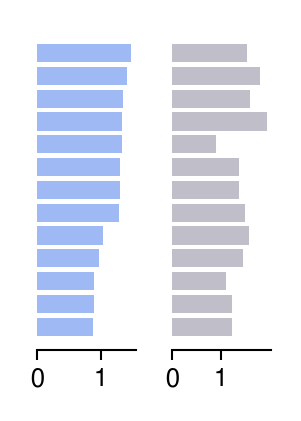

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Initialize a list to hold results
results = []

dataframes = [combined_sigs_blood, combined_sigs_bone, combined_sigs_brain]
diseases = ['Blood', 'Bone', 'Stacked']  # Replace with your actual disease names

# Calculate Cohen's d and p-values for 'Bio' and 'Psycho'
for disease, df in zip(diseases, dataframes):
    for nci in df.filter(like='NCI').columns[1:]:
        nci_name = rename[nci.split('_')[1]]
        # Extract the groups for 'Bio'
        group1 = df[df[nci] == 1]['Bio']
        group2 = df[df['Dx'] == 0]['Bio']
        # Extract the groups for 'Psycho'
        group3 = df[df[nci] == 1]['Psycho']
        group4 = df[df['Dx'] == 0]['Psycho']
        
        # Calculate Cohen's d and p-value for 'Bio'
        d_bio, p_bio = cohens_d_and_pvalue(group1, group2)
        # Calculate Cohen's d and p-value for 'Psycho'
        d_psycho, p_psycho = cohens_d_and_pvalue(group3, group4)
        
        # Store the results
        results.append({'Disease': disease, 'NCI': nci_name, 'Cohens_d_Bio': d_bio, 'p_value_Bio': p_bio,
                        'Cohens_d_Psycho': d_psycho, 'p_value_Psycho': p_psycho})

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

    
def plot_bar(disease,w,h):
    # Filter the results for the current disease and sort by Cohen's d
    current_results = results_df[results_df['Disease'] == disease].sort_values(by='Cohens_d_Bio', ascending=False)
    
    # Create a new figure with a custom size for each disease
    fig, ax = plt.subplots(ncols=2,figsize=(w, h))  # Change figsize as needed
    ax = ax.ravel()
    
    # Create a horizontal bar plot of Cohen's d values
    bars = ax[0].barh(current_results['NCI'], current_results['Cohens_d_Bio'], color=color_mapping[disease])
    ax[0].tick_params(left=False, axis='y', labelsize=5)
    ax[0].tick_params(axis='x', labelsize=6)
    ax[0].set_title("")
    ax[0].set_xlabel("")
    ax[0].invert_yaxis()  # To align the highest values at the top
    sns.despine()
    bars = ax[1].barh(current_results['NCI'], current_results['Cohens_d_Psycho'], color=color_mapping['Psychosocial'])
    ax[1].tick_params(left=False, axis='y', labelsize=5)
    ax[1].tick_params(axis='x', labelsize=6)
    ax[1].set_title("")
    ax[1].set_xlabel("")
    ax[1].invert_yaxis()  # To align the highest values at the top
    sns.despine(top=True,left=True,right=True)
    
    # # Move the y-tick labels to start at the beginning of the bars (at the y-axis)
    # for bar, label in zip(bars, current_results['NCI']):
    #     ax[0].text(0, bar.get_y() + bar.get_height() / 2, f' {label}', 
    #             va='center', ha='left', color='black', fontsize=5)

    # Hide the original y-axis labels since we are using text labels now
    ax[0].set_yticklabels([])
    ax[1].set_yticklabels([])
    ax[0].set_xticks([0,1])
    ax[1].set_xticks([0,1])

    # Display the plot
    plt.tight_layout()
    plt.show()
    # Save the figure if needed
    # fig.savefig(f"/Users/Patty/Desktop/Biomarker_Paper/Fig_5_Stratification/{disease}_Cohens_d.pdf", dpi=300, transparent=True, bbox_inches='tight')

plot_bar('Blood',1,1.4)

## Calculate risk score associations with pain sites for each condition in each risk score

In [18]:
import statsmodels.stats.multitest as smm
from scipy.stats import spearmanr

# Initialize lists to hold results and p-values
results = []
p_values_bio = []
p_values_psycho = []

dataframes = [combined_sigs_blood, combined_sigs_bone, combined_sigs_brain]
diseases = ['Blood', 'Bone', 'Stacked']  # Replace with your actual disease names

# Significance level (usually 0.05)
alpha = 0.05

# Calculate Cohen's d and store p-values for 'Bio' and 'Psycho'
for disease, df in zip(diseases, dataframes):
    if disease == 'Blood':
        timepoint = 'T0'
    else:
        timepoint = 'T2'
    
    for nci in df.filter(like='NCI').columns[1:]:
        nci_name = rename[nci.split('_')[1]]
            
        tmp = df[df[nci] == 1]
        
        d_bio, p_bio = spearmanr(tmp[f'NumberChronicPainTypes_{timepoint}'], tmp['Bio'])
        d_psycho, p_psycho = spearmanr(tmp[f'NumberChronicPainTypes_{timepoint}'], tmp['Psycho'])

        # Store the p-values separately for 'Bio' and 'Psycho'
        p_values_bio.append(p_bio)
        p_values_psycho.append(p_psycho)

        # Store the initial results (without FDR correction)
        results.append({'Disease': disease, 'NCI': nci_name, 'r_Bio': d_bio**2, 'p_value_Bio': p_bio,
                        'r_Psycho': d_psycho**2, 'p_value_Psycho': p_psycho})

# Apply the FDR correction
_, p_values_bio_corrected = smm.fdrcorrection(p_values_bio)
_, p_values_psycho_corrected = smm.fdrcorrection(p_values_psycho)

# Add FDR-corrected p-values and significance to the results
for i, result in enumerate(results):
    result['bio_fdr'] = p_values_bio_corrected[i]
    result['psycho_fdr'] = p_values_psycho_corrected[i]
    result['bio_significant'] = p_values_bio_corrected[i] < alpha
    result['psycho_significant'] = p_values_psycho_corrected[i] < alpha

# Create a DataFrame from the results
results_df = pd.DataFrame(results)


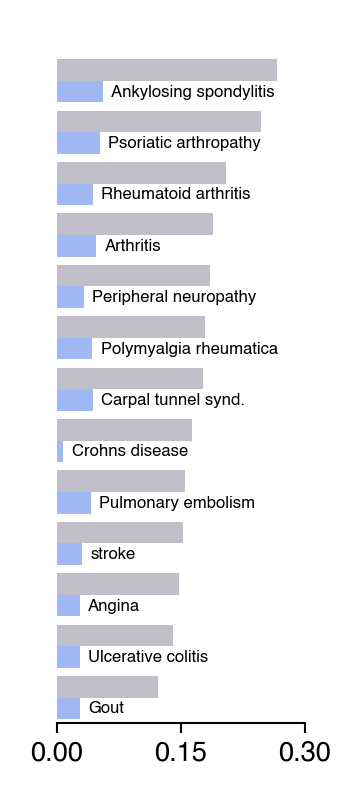

In [20]:
modality = 'Blood'
df = results_df[results_df['Disease'] == modality].sort_values(by='r_Bio', ascending=False)

# Sort the DataFrame by r_Psycho in descending order
df_sorted = df.sort_values('r_Psycho', ascending=False)

# Setting the positions and width for the bars
pos = list(range(len(df_sorted['NCI'])))
width = 0.42  # Reduced width for closer bars

# Plotting the bars
fig, ax = plt.subplots(figsize=(1.2, 2.65))

# Create a bar with r_Bio data
bar_bio = plt.barh([p + width/2 for p in pos], 
        df_sorted['r_Bio'], 
        width, 
        color=color_mapping[modality])

# Create a bar with r_Psycho data
bar_psycho = plt.barh([p - width/2 for p in pos], 
        df_sorted['r_Psycho'], 
        width, 
        color=color_mapping['Psychosocial'])
    
# Remove y-axis, ticks, tick labels, and labels
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([0,0.15,.3])

# Invert y-axis to have the highest value at the top
ax.set_ylim([min(pos) - 1, max(pos) + 0.5])
ax.invert_yaxis()

# Add text labels for each NCI
for rect, nci in zip(bar_bio.patches, df_sorted['NCI']):
    width = rect.get_width()
    ax.text(rect.get_x() + width + 0.01, rect.get_y() + rect.get_height()/2., 
            nci, ha='left', va='center', fontsize=4)
    
# Adding the x-axis label
plt.tight_layout()
plt.xlabel('')

# Output the final plot
plt.show()
# fig.savefig(f"/Users/Patty/Desktop/Biomarker_Paper/Fig_5_Stratification/{modality}_spearman_r2.pdf", dpi=300, transparent=True, bbox_inches='tight')


## Hexbin plot (taken out)

Index(['gout', 'polymyalgia rheumatica', 'stroke', 'rheumatoid arthritis',
       'crohns disease', 'angina', 'psoriatic arthropathy',
       'peripheral neuropathy', 'ankylosing spondylitis',
       'carpal tunnel syndrome', 'pulmonary embolism +/- dvt',
       'ulcerative colitis', 'arthritis (nos)'],
      dtype='object')
Index(['osteoporosis', 'gout', 'spinal stenosis', 'carpal tunnel syndrome'], dtype='object')
Index(['multiple sclerosis', 'stroke', 'fibromyalgia',
       'chronic fatigue syndrome', 'cervical spondylosis'],
      dtype='object')


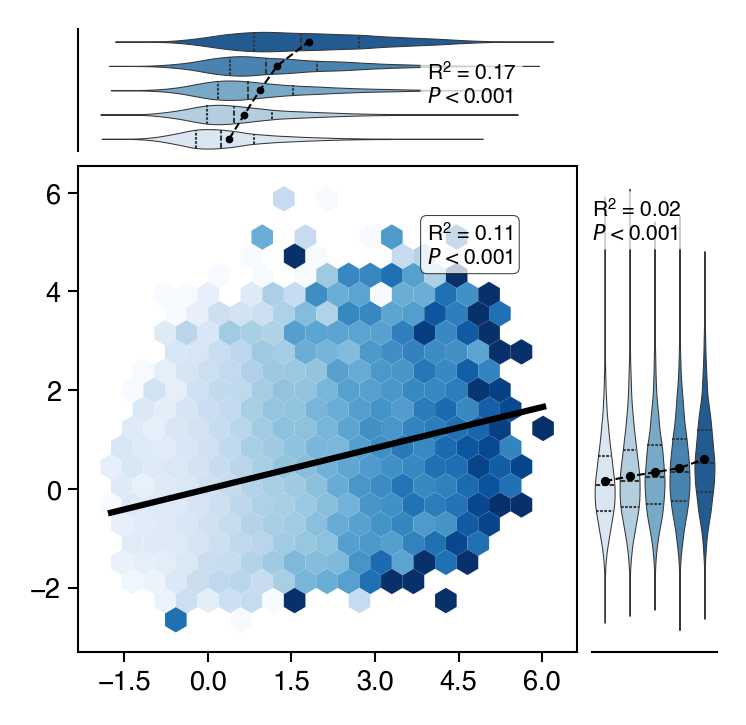

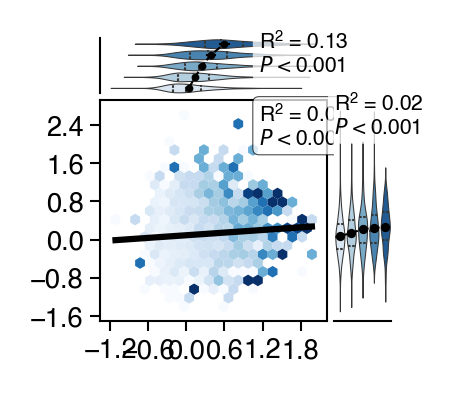

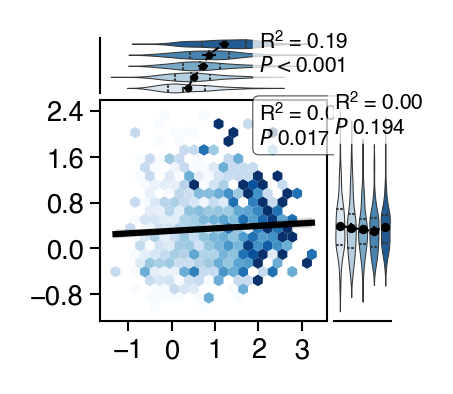

In [57]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr

def create_pivot_heatmap(merged_auc, dic, UKB, mod, T, strata, n):
    
    # Extract the top n indices based on the specified modality
    n = merged_auc.sort_values(mod, ascending=False).index[:n]
    print(n)
    
    combined_df = pd.DataFrame()
    ncis = []
    for nci in n:
        tmp = merge_dataframe(dic, nci, mod, 'Psychosocial')
        combined_df = pd.concat([combined_df, tmp])
        ncis.append(f'NCI_{nci}_{T}')
        
    combined_df = combined_df.groupby('eid').mean()
    combined_df['Dx'] = np.where(combined_df['Dx'] > 0, 1, 0)
    
    df = UKB[['eid', f'NCI_{T}', f'ChronicPain_{T}', f'NumberChronicPainTypes_{T}'] + ncis].merge(combined_df, on='eid')
    df_dx = df[(df['Dx'] == 1)]
    # df_dx = df[(df['Dx'] == 1) | (df[f'NCI_{T}'] == 0)] # Include healthy
    
    df_dx['bio_strata'] = pd.qcut(df_dx[mod], q=strata, labels=False)
    df_dx['psycho_strata'] = pd.qcut(df_dx['Psychosocial'], q=strata, labels=False)
    df_dx['Bio'] = df_dx[mod]
    df_dx['Psycho'] = df_dx['Psychosocial']
    df_dx['Bio'] = np.log(df_dx[mod] / (1 - df_dx[mod]))
    df_dx['Psycho'] = np.log(df_dx['Psychosocial'] / (1 - df_dx['Psychosocial']))
    # df_dx = df_dx[['Dx','Bio','Psycho']]
    
    return df_dx

def create_pointplots(combined_sigs, T, h, w, mod):
    """Generates a scatterplot with adjoining point plots based on the dataframe and T value provided.
    
    Parameters:
    - combined_sigs: DataFrame with data.
    - T: Value to be used in the 'NumberChronicPainTypes_T' column name.
    
    Outputs:
    - A matplotlib plot.
    """
    
    fig = plt.figure(figsize=(h, w))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 4])
    cmap = 'Blues'
    
    ax0 = plt.subplot(gs[0])  # For the top pointplot
    ax1 = plt.subplot(gs[1])  # Empty plot (top right corner)
    ax2 = plt.subplot(gs[2])  # For the main scatterplot and regplot
    ax3 = plt.subplot(gs[3])  # For the right pointplot

    ax1.axis('off')

    # scatter = sns.scatterplot(data=combined_sigs, x='Psycho', y='Bio', hue=f'NumberChronicPainTypes_{T}', palette='Oranges', s=5, linewidth=0, ax=ax2)
    # scatter.get_legend().remove()  # Remove legend
    cs_sample = combined_sigs
    scatter = ax2.hexbin(
    cs_sample['Psycho'], 
    cs_sample['Bio'], 
    C=cs_sample[f'NumberChronicPainTypes_{T}'], 
    gridsize=20,
    cmap=cmap, 
    reduce_C_function=np.mean,
    edgecolors=None,
    linewidth=0.025,
    # marginals=True
    )
    sns.regplot(data=combined_sigs, x='Psycho', y='Bio', color='k', scatter=False, ax=scatter.axes, line_kws={'linewidth': 1.5})

    # pointplot0 = sns.pointplot(data=combined_sigs, x='Psycho', y=f'NumberChronicPainTypes_{T}', palette='Oranges', join=True, scale=0.4, ci='sd', orient='h', ax=ax0)
    pointplot0 = sns.violinplot(data=combined_sigs, x='Psycho', y=f'NumberChronicPainTypes_{T}', linewidth=0.25, fill=True, inner='quart', palette=cmap, ax=ax0, orient='h')
    sns.pointplot(data=combined_sigs, x='Psycho', y=f'NumberChronicPainTypes_{T}', scale=.25, ax=ax0, orient='h', join=True, linestyles='--', markers='o', color='k', estimator=np.mean)
    ax0.set(xticks=[], yticks=[], xlabel='', ylabel='')
    ax0.invert_yaxis()
    for line in pointplot0.lines:
        line.set_linewidth(.5)
    sns.despine(ax=ax0,top=True,right=True,bottom=True)

    # pointplot3 = sns.pointplot(data=combined_sigs, y='Bio', x=f'NumberChronicPainTypes_{T}', palette='Oranges', join=True, scale=0.4, ci='sd', ax=ax3, orient='v')
    pointplot3 = sns.violinplot(data=combined_sigs, y='Bio', x=f'NumberChronicPainTypes_{T}', linewidth=0.25, fill=True, inner='quart', palette=cmap, ax=ax3, orient='v')
    mean_point = sns.pointplot(data=combined_sigs, y='Bio', x=f'NumberChronicPainTypes_{T}', scale=.3, ax=ax3, orient='v', join=True, linestyles='--', markers='o', color='k', estimator=np.mean)        
    ax3.set(xticks=[], yticks=[], xlabel='', ylabel='')
    for line in pointplot3.lines:
        line.set_linewidth(0.5)
    sns.despine(ax=ax3,top=True,right=True,left=True)
        
    ax2.set(xlabel='', ylabel='')  # Remove labels

    xmin0, xmax0 = ax0.get_xlim()
    ymin3, ymax3 = ax3.get_ylim()
    ax0.set_xlim(xmin0, xmax0+.01)
    ax3.set_ylim(ymin3, ymax3+.01)

    ax2.xaxis.set_major_locator(MaxNLocator(nbins=6))
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))

    def format_p_value(p_value):
        if p_value < 0.001:
            return '< 0.001'
        else:
            return f'{p_value:.3f}'
        
    #### Zoomin out #####
     # Determine current axis limits
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    # Adjust the axis limits to "zoom out"
    padding_x = 0.025 * (xmax - xmin)  # 10% of the range
    padding_y = 0.025 * (ymax - ymin)  # 10% of the range
    ax2.set_xlim(xmin - padding_x, xmax + padding_x)
    ax2.set_ylim(ymin - padding_y, ymax + padding_y)

    correlation0, p_value0 = pearsonr(combined_sigs['Psycho'], combined_sigs[f'NumberChronicPainTypes_{T}'])
    r_squared0 = correlation0**2
    p_value0 = format_p_value(p_value0)
    ax0.annotate(r'$R^2$ = %.2f' % r_squared0 + '\n' + r'$\it{P}$ ' + p_value0,
                 xy=(0.7, 0.4), xycoords='axes fraction', fontsize=5,
                 bbox=dict(facecolor='white', edgecolor='k', alpha=0.75, boxstyle="round,pad=0.3", linewidth=0))

    correlation3, p_value3 = pearsonr(combined_sigs['Bio'], combined_sigs[f'NumberChronicPainTypes_{T}'])
    r_squared3 = correlation3**2
    p_value3 = format_p_value(p_value3)
    ax3.annotate(r'$R^2$ = %.2f' % r_squared3 + '\n' + r'$\it{P}$ ' + p_value3,
                 xy=(0.001, 0.85), xycoords='axes fraction', fontsize=5,
                 bbox=dict(facecolor='white', edgecolor='k', alpha=0.75, boxstyle="round,pad=0.3", linewidth=0))

    correlation, p_value = pearsonr(combined_sigs['Psycho'], combined_sigs['Bio'])
    r_squared = correlation**2
    p_value = format_p_value(p_value)
    ax2.annotate(r'$R^2$ = %.2f' % r_squared + '\n' + r'$\it{P}$ ' + p_value,
                 xy=(0.7, 0.8), xycoords='axes fraction', fontsize=5,
                 bbox=dict(facecolor='white', edgecolor='k', alpha=0.75, boxstyle="round,pad=0.3", linewidth=0.25))

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    
    fig.savefig(f"/Users/Patty/Desktop/Biomarker_Paper/Fig_5_Stratification/Regplot_{mod}.pdf", 
        dpi=300, transparent=True, bbox_inches='tight')

    plt.show()

TP = 'T0'
combined_sigs_blood = create_pivot_heatmap(merged_auc, diag_T0, UKB, 'Blood', TP, 5, 13)
# combined_sigs_blood = combined_sigs_blood[(combined_sigs_blood.Bio > -5) & (combined_sigs_blood.Bio < 5)]
TP = 'T2'
combined_sigs_bone = create_pivot_heatmap(merged_auc, diag_T2, UKB, 'Bone', TP, 5, 4)
combined_sigs_bone = combined_sigs_bone[(combined_sigs_bone.Bio > -3) & (combined_sigs_bone.Bio < 5)] # Remove outlier for visualization
combined_sigs_brain = create_pivot_heatmap(merged_auc, diag_T2, UKB, 'Stacked', TP, 5, 5)
combined_sigs_brain = combined_sigs_brain[(combined_sigs_brain.Bio > -2) & (combined_sigs_brain.Bio < 2.5)]

create_pointplots(combined_sigs_blood, 'T0', 2.75, 2.75, 'Blood')

create_pointplots(combined_sigs_bone, 'T2', 1.25, 1.25, 'Bone')

create_pointplots(combined_sigs_brain, 'T2', 1.25, 1.25, 'Brain')


## Stratify biological and psychosocial risk scores into quintiles, calculate the odds of any diagnosis based on combinations of biological and psychosocial quintiles

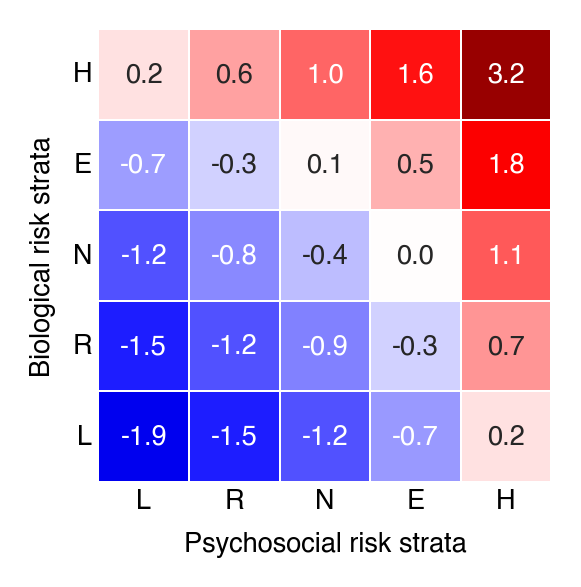

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

# Probabilities
def merge_dataframe(dic, nci, mod1, mod2):
    a_data = [pd.DataFrame(dic[i]['roc_curve'].T, columns=['eid',f'y_true_{mod1}',f'{nci}_{mod1}']) for i in dic.keys() if f'{nci}_{mod1}' in i]
    a_data_o = pd.concat([pd.DataFrame(dic[i]['roc_curve_other'].T, columns=['eid',f'y_true_{mod1}',f'{nci}_{mod1}']) for i in dic.keys() if f'{nci}_{mod1}' in i])
    a = pd.concat([pd.concat(a_data),a_data_o]).groupby('eid').mean()
    a.columns = ['Dx',mod1]
    
    b_data = [pd.DataFrame(dic[i]['roc_curve'].T, columns=['eid',f'y_true_{mod2}',f'{nci}_Psychosocial']) for i in dic.keys() if f'{nci}_{mod2}' in i]
    b_data_o = pd.concat([pd.DataFrame(dic[i]['roc_curve_other'].T, columns=['eid',f'y_true_{mod2}',f'{nci}_{mod2}']) for i in dic.keys() if f'{nci}_{mod2}' in i])
    b = pd.concat([pd.concat(b_data),b_data_o]).groupby('eid').mean()
    b.columns = ['Dx',mod2]
    b = b.drop(columns='Dx')

    merged_df = a.merge(b, on='eid')
    
    return merged_df


def calc_odds_ratio(data, bio_decile, psycho_decile):
    # Create a 2x2 contingency table
    strata = data[(data['bio_strata'] == bio_decile) & (data['psycho_strata'] == psycho_decile)]
    rest = data[(data['bio_strata'] != bio_decile) | (data['psycho_strata'] != psycho_decile)]
    contingency_table = [[strata['Dx'].sum(), len(strata) - strata['Dx'].sum()],
                         [rest['Dx'].sum(), len(rest) - rest['Dx'].sum()]]

    # Calculate odds ratio
    odds_ratio, _ = scipy.stats.fisher_exact(contingency_table)
    return odds_ratio

def generate_heatmap(dic, mod, T, n, strata, merged_auc, h, w):
    
    # Instantiate DF
    combined_df = pd.DataFrame()
    
    # Extract the top n indices based on the specified modality
    n = merged_auc.sort_values(mod, ascending=False).index[:n]
    # n = ['angina']

    combined_df = pd.DataFrame()
    ncis = []
    for nci in n:
        tmp = merge_dataframe(dic, nci, mod, 'Psychosocial')
        combined_df = pd.concat([combined_df, tmp])
        ncis.append(f'NCI_{nci}_{T}')
        
    combined_df = combined_df.groupby('eid').mean()
    combined_df['Dx'] = np.where(combined_df['Dx'] > 0, 1, 0)
    
    df = UKB[['eid', f'NCI_{T}', f'ChronicPain_{T}', f'NumberChronicPainTypes_{T}'] + ncis].merge(combined_df, on='eid')
    df_dx = df[(df['Dx'] == 1) | (df[f'NCI_{T}'] == 0)]
    
    # Logit transform
    df_dx['Bio'], df_dx['Psycho'] = np.log(df_dx[mod] / (1 - df_dx[mod])), np.log(df_dx['Psychosocial'] / (1 - df_dx['Psychosocial']))

    df_dx['bio_strata'] = pd.qcut(df_dx[mod], labels=False, q=strata)
    df_dx['psycho_strata'] = pd.qcut(df_dx['Psychosocial'], labels=False, q=strata) # [f'bin {i}' for i in range(strata)]
        
    average_pivot_table = pd.DataFrame({
        i: {j: calc_odds_ratio(df_dx, i, j) for j in range(strata)}
        for i in range(strata)
    })

    if mod == 'Blood':
        fig, ax = plt.subplots(figsize=(h, w))
        sns.heatmap(np.log(average_pivot_table.T), cmap='seismic', annot=True, fmt=".1f",
                    linewidth=.1, center=0, vmin=-2, vmax=3.5, cbar=False, square=True)
        ax.set_title('')
        ax.set_xlabel('Psychosocial risk strata')
        ax.set_ylabel('Biological risk strata')
        ax.invert_yaxis()
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

        x_ticks = np.arange(1, strata + 1)
        y_ticks = np.arange(1, strata + 1)
        ax.set_xticklabels(['L','R','N','E','H'])
        ax.set_yticklabels(['L','R','N','E','H'], rotation=0)

        plt.tick_params(axis='both', which='both', length=0)
        
    if mod in ['Stacked', 'Bone']:
        fig, ax = plt.subplots(figsize=(h, w))
        sns.heatmap(np.log(average_pivot_table.T), cmap='seismic', annot=False, fmt=".1f",
                    linewidth=.1, center=0, vmin=-4, vmax=4, cbar=False, square=True)
        ax.invert_yaxis()
        plt.tick_params(axis='both', which='both', length=0, labelsize=0)
        plt.axis('off')  # This will remove the axis and we won't show any labels or titles
        
    plt.show()
    
    # fig.savefig(f"/Users/Patty/Desktop/Biomarker_Paper/Fig_5_Stratification/{mod}_OR_Strata.pdf", 
    #     dpi=300, transparent=False, bbox_inches='tight')
    
    return df_dx, df, average_pivot_table

df_dx, df_full, table = generate_heatmap(diag_T0, 'Blood', 'T0', 13, 5, merged_auc, 2, 2)

# df_dx, df_full, table = generate_heatmap(diag_T2, 'Stacked', 'T2', 4, 5, merged_auc, 1.25, 1.25)
# df_dx, df_full, table = generate_heatmap(diag_T2, 'Bone', 'T2', 4, 5, merged_auc, 1.25, 1.25)

## Calculate odds ratio of diagnosis for individual diagnoses based on blood risk quintiles, psychosocial risk quintiles, and union of the risk quintiles

In [22]:
# Adjusted function to calculate the odds ratios for each illness compared to healthy controls within and across all strata

def calculate_strata_odds_ratios(df, illness_columns, strata_cols):
    # Initialize a dictionary to hold the DataFrame for each strata column and the combined strata
    odds_ratios_dfs = {}

    # Identify healthy controls as those without any of the illnesses
    healthy_controls = df[df[illness_columns].sum(axis=1) == 0]

    for strata_col in strata_cols + ['combined']:
        # Initialize a DataFrame to hold the odds ratios for each illness
        odds_ratios_df = pd.DataFrame(index=np.arange(len(df[strata_cols[0]].unique())), columns=illness_columns)

        # Get unique values of the strata
        strata_bins = np.sort(df[strata_cols[0]].unique())

        # Calculate odds for each bin or the combined strata
        for bin in strata_bins:
            if strata_col != 'combined':
                # Select cases within the current bin
                cases_in_bin = df[df[strata_col] == bin]
                # Select healthy controls within the current bin
                controls_in_bin = healthy_controls[healthy_controls[strata_col] == bin]
                # Select healthy controls in all other bins
                controls_out_bin = healthy_controls[healthy_controls[strata_col] != bin]
            else:
                # Select cases where bio_strata equals psycho_strata and equals the current bin
                cases_in_bin = df[(df[strata_cols[0]] == bin) & (df[strata_cols[1]] == bin)]
                # Select healthy controls where bio_strata equals psycho_strata and equals the current bin
                controls_in_bin = healthy_controls[(healthy_controls[strata_cols[0]] == bin) & (healthy_controls[strata_cols[1]] == bin)]
                # Select healthy controls where bio_strata and psycho_strata do not equal the current bin
                controls_out_bin = healthy_controls[(healthy_controls[strata_cols[0]] != bin) | (healthy_controls[strata_cols[1]] != bin)]

            # Calculate the odds ratios for each illness
            for illness in illness_columns:
                # Calculate the odds of having the illness in the current bin against healthy controls in the same bin
                event_in_bin = cases_in_bin[illness].sum()
                nonevent_in_bin = len(controls_in_bin)
                odds_in_bin = event_in_bin / nonevent_in_bin if nonevent_in_bin != 0 else np.nan

                # Calculate the odds of having the illness in all other bins against healthy controls in those bins
                event_out_bin = df[(df[strata_col] != bin) & (df[illness] == 1)][illness].sum() if strata_col != 'combined' else \
                                df[((df[strata_cols[0]] != bin) | (df[strata_cols[1]] != bin)) & (df[illness] == 1)][illness].sum()
                nonevent_out_bin = len(controls_out_bin)
                odds_out_bin = event_out_bin / nonevent_out_bin if nonevent_out_bin != 0 else np.nan

                # Calculate the odds ratio
                odds_ratio = odds_in_bin / odds_out_bin if (odds_in_bin is not np.nan and odds_out_bin is not np.nan) else np.nan
                odds_ratios_df.at[bin, illness] = odds_ratio

        # Reset the index to make the strata column again and sort the index
        odds_ratios_df = odds_ratios_df.reset_index().rename(columns={'index': strata_col}).set_index(strata_col).sort_index()

        # Store the DataFrame in the dictionary
        odds_ratios_dfs[strata_col] = odds_ratios_df.replace({0: np.nan})

    return odds_ratios_dfs



illness_columns = [col for col in df_dx.columns if col.startswith('NCI')][1:]
# Re-calculate the odds ratios for each strata and the combined strata against healthy controls only
strata_cols = ['bio_strata', 'psycho_strata']
odds_ratios_dfs = calculate_strata_odds_ratios(df_dx, illness_columns, strata_cols)


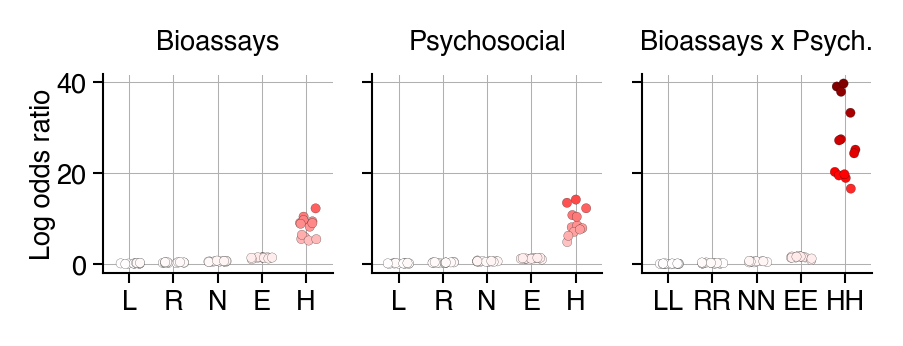

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Log transform all the odds ratios and replace non-positive values with NaN
bio_strata_log = np.log(odds_ratios_dfs['bio_strata'])
psycho_strata_log = np.log(odds_ratios_dfs['psycho_strata'])
combined_strata_log = np.log(odds_ratios_dfs['combined'])

bio_strata_log = odds_ratios_dfs['bio_strata']
psycho_strata_log = odds_ratios_dfs['psycho_strata']
combined_strata_log = odds_ratios_dfs['combined']

# Melt the DataFrames for plotting
bio_strata_melted = bio_strata_log.T.melt(value_name='log odds ratio')
psycho_strata_melted = psycho_strata_log.T.melt(value_name='log odds ratio')
combined_strata_melted = combined_strata_log.T.melt(value_name='log odds ratio')

# Establish custom colormap
vcenter = 0
vmin, vmax = combined_strata_melted["log odds ratio"].min(), combined_strata_melted["log odds ratio"].max()
# normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin-.1, vmax=vmax+0.1)
colormap = cm.seismic

# Initialize the matplotlib figure and axes
fig, axes = plt.subplots(1, 3, figsize=(3, 1.15), sharex=False, sharey=True)

# First subplot for bio_strata
sns.scatterplot(ax=axes[0], data=bio_strata_melted, x='bio_strata', y='log odds ratio', hue='log odds ratio', 
                palette=colormap, edgecolor='k', linewidth=.05, s=5, hue_norm=normalize)
axes[0].set_title('Bioassays',fontsize=6.5)
axes[0].set_xlabel('')
axes[0].set_ylabel('Log odds ratio',labelpad=0)
axes[0].get_legend().remove()
axes[0].set_xticks([0,1,2,3,4])
axes[0].set_xticklabels(['L','R','N','E','H'])
axes[0].grid(linewidth=.25,zorder=-10)
sns.despine(ax=axes[0],left=False)

# Second subplot for psycho_strata
sns.scatterplot(ax=axes[1], data=psycho_strata_melted, x='psycho_strata', y='log odds ratio', hue='log odds ratio', 
                palette=colormap, edgecolor='k', linewidth=.05, s=5, hue_norm=normalize)
axes[1].set_title('Psychosocial',fontsize=6.5)
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].get_legend().remove()
axes[1].set_xticks([0,1,2,3,4])
axes[1].set_xticklabels(['L','R','N','E','H'])
axes[1].grid(linewidth=.25,zorder=-10)
sns.despine(ax=axes[1],left=False)

# Third subplot for combined strata
sns.scatterplot(ax=axes[2], data=combined_strata_melted, x='combined', y='log odds ratio', hue='log odds ratio', 
                palette=colormap, edgecolor='k', linewidth=.05, s=5, hue_norm=normalize)
axes[2].set_title('Bioassays x Psych.',fontsize=6.5)
axes[2].set_xlabel('')
axes[2].set_ylabel('')
axes[2].get_legend().remove()
axes[2].set_xticks([0,1,2,3,4])
axes[2].set_xticklabels(['LL','RR','NN','EE','HH'])
axes[2].grid(linewidth=.25,zorder=-10)

axes[0].set_axisbelow(True)
axes[1].set_axisbelow(True)
axes[2].set_axisbelow(True)

# Tweak the points to mimic `sns.stripplot`
for ax in axes:
    pts = ax.collections[0]
    pts.set_offsets(pts.get_offsets() + np.c_[np.random.uniform(-.25, .25, len(combined_strata_melted)), np.zeros(len(combined_strata_melted))])
    ax.margins(x=0.15)


# Adjust the layout and show the plot
sns.despine()
plt.tight_layout()
plt.show()

# # Colorbar
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(combined_strata_melted["log odds ratio"])
fig.colorbar(scalarmappaple)

# Save the plot to a file
# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_5_Stratification/log_OR_dots.pdf", dpi=300, transparent=False, bbox_inches='tight')


## Estimate the relative hazard of a pain-diagnosis associated with different combinations of blood and psychosocial risk quintiles at baseline in participants with no diagnoses

In [26]:
# Load in data containing date of diagnoses until 2021
fo_age = pd.read_csv('/Users/Patty/Desktop/EVP_lab/UKB_first_occurences_dates.csv')
fo_age.columns = [i.replace(' ','_') for i in fo_age.columns]
fo_age = fo_age[[
        'eid',
        'other_arthritis',
        'seropositive_rheumatoid_arthritis', 'other_rheumatoid_arthritis',
        'angina_pectoris',
        'gout',
        'ankylosing_spondylitis',
        "crohn's_disease_[regional_enteritis]",
        'inflammatory_polyneuropathy', 'other_polyneuropathies', 'polyneuropathy_in_diseases_classified_elsewhere',
        'ulcerative_colitis',
        'pulmonary_embolism',
        'subarachnoid_haemorrhage', 'intracerebral_haemorrhage', 'cerebral_infarction', 'stroke,_not_specified_as_haemorrhage_or_infarction',
        'psoriatic_and_enteropathic_arthropathies'
                ]]
fo_age = fo_age.apply(lambda col: pd.to_datetime(col) if col.dtypes == object else col)

icd_age = pd.read_csv('/Users/Patty/Desktop/EVP_lab/MF_tmp_ICD.csv')
icd_age.columns = ['carpal tunnel syndrome','pulmonary embolism +/- dvt','polymyalgia rheumatica','eid']
icd_age = icd_age.drop(columns='pulmonary embolism +/- dvt')
icd_age = icd_age.apply(lambda col: pd.to_datetime(col) if col.dtypes == object else col)

date_ass = pd.read_csv(home_dir + 'UKB_NoBrain_500K_V4.csv',low_memory=False,usecols=['eid','DateAssessment_T0']).dropna()
date_ass = date_ass.apply(lambda col: pd.to_datetime(col) if col.dtypes == object else col)


In [27]:
disease_mapping = {
    'arthritis (nos)': ['other_arthritis'],
    'rheumatoid arthritis': ['seropositive_rheumatoid_arthritis', 'other_rheumatoid_arthritis'],
    'angina': ['angina_pectoris'],
    'gout': ['gout'],
    'ankylosing spondylitis': ['ankylosing_spondylitis'],
    'crohns disease': ["crohn's_disease_[regional_enteritis]"],
    'peripheral neuropathy': ['inflammatory_polyneuropathy', 'other_polyneuropathies', 'polyneuropathy_in_diseases_classified_elsewhere'],
    'ulcerative colitis': ['ulcerative_colitis'],
    'pulmonary embolism +/- dvt': ['pulmonary_embolism'],
    'stroke': ['subarachnoid_haemorrhage', 'intracerebral_haemorrhage', 'cerebral_infarction', 'stroke,_not_specified_as_haemorrhage_or_infarction'],
    'psoriatic arthropathy': ['psoriatic_and_enteropathic_arthropathies'],
}

result_df = pd.DataFrame()

for disease, columns in disease_mapping.items():
    column_name = f"{disease}"

    if columns:
        # Use max function to ensure 1 if any of the related columns has a 1
        result_df[column_name] = fo_age[[f"{col}" for col in columns]].max(axis=1) # Should use min instead?
    else:
        result_df[column_name] = 0

# Set 'eid' as index for each timepoint's result_df
result_df = fo_age[['eid']].join(result_df)
result_df.set_index('eid', inplace=True)

In [28]:
mod = 'Blood'
T = 'T0'
strata = 5
n = merged_auc.sort_values(mod, ascending=False).index[:13]

combined_df = pd.DataFrame()
ncis = []
for nci in n:
    tmp = merge_dataframe(diag_T0, nci, mod, 'Psychosocial')
    combined_df = pd.concat([combined_df, tmp])
    ncis.append(f'NCI_{nci}_{T}')

combined_df = combined_df.groupby('eid').mean()
combined_df['Dx'] = np.where(combined_df['Dx'] > 0, 1, 0)

df = UKB[['eid', f'NCI_{T}', f'ChronicPain_{T}', f'NumberChronicPainTypes_{T}'] + ncis].merge(combined_df, on='eid')

# Logit transform
df['Bio'], df['Psycho'] = np.log(df[mod] / (1 - df[mod])), np.log(df['Psychosocial'] / (1 - df['Psychosocial']))

df['bio_strata'] = pd.qcut(df[mod], labels=False, q=strata)
df['psycho_strata'] = pd.qcut(df['Psychosocial'], labels=False, q=strata)
df['combined_strata'] = df.apply(lambda row: f"{int(row['bio_strata'])}_{int(row['psycho_strata'])}", axis=1)

In [29]:
dx_dates = result_df.merge(icd_age,on='eid')

dx_dates = dx_dates.merge(date_ass,on='eid')

dx_dates = dx_dates.merge(df[['eid','Dx','NCI_T0','bio_strata','psycho_strata','combined_strata']],on='eid')
dx_dates = dx_dates[dx_dates['Dx'] == 0]

In [30]:
import pandas as pd
# Convert all disease columns to datetime, errors='coerce' will handle None values and NaNs
disease_columns = ['arthritis (nos)', 'rheumatoid arthritis', 'angina', 'gout', 'ankylosing spondylitis', 
                   'crohns disease', 'peripheral neuropathy', 'ulcerative colitis', 
                   'pulmonary embolism +/- dvt', 'stroke', 'psoriatic arthropathy', 
                   'carpal tunnel syndrome', 'polymyalgia rheumatica']

for col in disease_columns:
    dx_dates[col] = pd.to_datetime(dx_dates[col], errors='coerce')

# Find the earliest date of disease occurrence in each row
dx_dates['disease_incidence'] = dx_dates[disease_columns].min(axis=1, skipna=True)
dx_dates = dx_dates[~(dx_dates.DateAssessment_T0 > dx_dates.disease_incidence)]
# dx_dates = dx_dates[(dx_dates['NCI_T0'] == 0) | (~dx_dates.disease_incidence.isnull())]
dx_dates = dx_dates.merge(df[['Bio','Psycho','eid']],on='eid')

### Here, we use the lifelines python package to plot hazard curves and hazard ratios for each condition

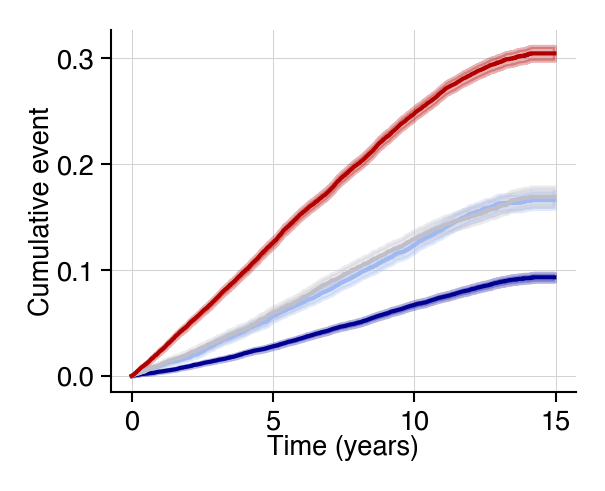

<Figure size 1800x1200 with 0 Axes>

In [35]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Convert 'start_date' and 'disease_incidence' to datetime if they are not already
dx_dates['start_date'] = pd.to_datetime(dx_dates['DateAssessment_T0'])
dx_dates['disease_incidence'] = pd.to_datetime(dx_dates['disease_incidence'])

# Find the latest disease incidence date in the dataset
latest_disease_incidence_date = dx_dates['disease_incidence'].max()

# Calculate the duration for each subject
# If disease_incidence is NaT (not a timestamp), use the latest disease incidence date as the end of follow-up
dx_dates['duration'] = (dx_dates['disease_incidence'].fillna(latest_disease_incidence_date) - dx_dates['start_date']).dt.days

# Limit the analysis to 15 years
max_duration = 15 * 365  # 15 years in days
dx_dates['duration'] = dx_dates['duration'].clip(upper=max_duration)

# Create an event column (1 if disease occurred, 0 if censored or beyond time limit)
dx_dates['event'] = (~dx_dates['disease_incidence'].isna()) & (dx_dates['duration'] <= max_duration)

# Convert duration from days to years
dx_dates['duration_years'] = dx_dates['duration'] / 365.25

strata_labels = ['0_0', '0_4', '4_0', '4_4']

# Plotting setup
kmf = KaplanMeierFitter()
fig,ax = plt.subplots(figsize=(2,1.6))

# Get colors from the coolwarm colormap
colors = cm.coolwarm(np.linspace(0, 1, len(strata_labels)))
# colors = cm.seismic(np.linspace(0, 1, len(std_dev_labels)))
colors = ['#000092', '#3131ff', '#ff3131', '#b20000']
colors = ['#000092', '#9EB9F3', '#C0BFC9', '#b20000']

# Calculate and plot the Kaplan-Meier estimate and confidence intervals for each group
for bin_label, color in zip(strata_labels, colors):
    data = dx_dates[dx_dates['combined_strata'] == bin_label]
    kmf.fit(data['duration_years'], data['event'])

    # Get the survival function and confidence intervals
    survival_function = kmf.survival_function_
    confidence_interval = kmf.confidence_interval_

    # Plot the survival function
    plt.plot(survival_function.index, 1 - survival_function, label=bin_label, color=color, linewidth=1)

    # Plot the confidence intervals
    lower = confidence_interval.iloc[:, 0]
    upper = confidence_interval.iloc[:, 1]
    plt.fill_between(survival_function.index, 1 - lower, 1 - upper, color=color, alpha=0.3)
    
    sns.despine()
    
plt.yticks([0,0.1,0.2,0.3])
plt.xticks([0,5,10,15])

# plt.xlim([0,15])
plt.xlabel('Time (years)',labelpad=0)
plt.ylabel('Cumulative event',labelpad=0)
plt.title('')
plt.legend('',frameon=False)
# plt.legend(frameon=False)

plt.grid(linewidth=.25,zorder=-10, color='lightgrey')
ax.set_axisbelow(True)

plt.show()
plt.tight_layout()

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_5_BioPsycho/Strata_hazard_plot_v2.pdf", 
# dpi=300, transparent=True, bbox_inches='tight')

In [37]:
# Calculating confidence intervals of Hazard curves
from lifelines import CoxPHFitter

tmp = dx_dates[dx_dates['combined_strata'] == '4_4']

# Initialize the Cox Proportional Hazards model
cph = CoxPHFitter()

# Fit the model with the risk combination as a covariate
cph.fit(tmp[['event','duration_years','Bio','Psycho']], duration_col='duration_years', event_col='event')

# Print the summary of the model
print(cph.summary)


               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
Bio        0.238892   1.269842  0.019231        0.201201        0.276584   
Psycho     0.115191   1.122087  0.014298        0.087168        0.143214   

           exp(coef) lower 95%  exp(coef) upper 95%          z             p  \
covariate                                                                      
Bio                    1.22287             1.318618  12.422382  1.975902e-35   
Psycho                 1.09108             1.153976   8.056599  7.844649e-16   

             -log2(p)  
covariate              
Bio        115.284972  
Psycho      50.179141  


In [38]:
from lifelines import CoxPHFitter
# Initialize the Cox Proportional Hazards model
cph = CoxPHFitter()

# List of your specific groups
groups = ['4_4', '4_0', '0_4', '0_0']

# Dictionary to store the model summaries for each group
model_summaries = {}

for group in groups:
    # Create a binary variable for the group
    dx_dates[f'is_{group}'] = (dx_dates['combined_strata'] == group).astype(int)

    # Fit the Cox model for this group
    cph.fit(dx_dates, duration_col='duration_years', event_col='event', formula=f'is_{group}')

    # Store the model summary
    model_summaries[group] = cph.summary

# Print the summaries for each group
for group, summary in model_summaries.items():
    print(f"Hazard Ratio for group {group} compared to all others:\n")
    print(summary, "\n")


Hazard Ratio for group 4_4 compared to all others:

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
is_4_4     0.816352   2.262233  0.013361        0.790165         0.84254   

           exp(coef) lower 95%  exp(coef) upper 95%          z    p  -log2(p)  
covariate                                                                      
is_4_4                2.203759             2.322258  61.098625  0.0       inf   

Hazard Ratio for group 4_0 compared to all others:

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
is_4_0     0.054907   1.056442  0.028305       -0.000571        0.110384   

           exp(coef) lower 95%  exp(coef) upper 95%         z         p  \
covariate                                                                 
is_4_0                 0.99943             1.1

In [39]:
# Using log-rank test to estimate significance of Hazard ratios
from lifelines.statistics import logrank_test

# List of strata labels
strata_labels = ['0_0', '0_4', '4_0', '4_4']

# Perform the log-rank test for each pair of groups
for i in range(len(strata_labels)):
    for j in range(i+1, len(strata_labels)):
        group1 = dx_dates[dx_dates['combined_strata'] == strata_labels[i]]
        group2 = dx_dates[dx_dates['combined_strata'] == strata_labels[j]]

        # Perform the log-rank test
        result = logrank_test(group1['duration_years'], group2['duration_years'], 
                              event_observed_A=group1['event'], event_observed_B=group2['event'])

        # Print the results
        print(f"Log-rank test between {strata_labels[i]} and {strata_labels[j]}:")
        print(f"Test statistic: {result.test_statistic}, p-value: {result.p_value}\n")


Log-rank test between 0_0 and 0_4:
Test statistic: 377.96641939897665, p-value: 3.44910790814226e-84

Log-rank test between 0_0 and 4_0:
Test statistic: 356.47031635729695, p-value: 1.6526192499370565e-79

Log-rank test between 0_0 and 4_4:
Test statistic: 3543.646997323633, p-value: 0.0

Log-rank test between 0_4 and 4_0:
Test statistic: 0.012167476927670532, p-value: 0.9121664714746979

Log-rank test between 0_4 and 4_4:
Test statistic: 602.1846671169534, p-value: 5.6055467472813874e-133

Log-rank test between 4_0 and 4_4:
Test statistic: 540.0470569727023, p-value: 1.8416002454436576e-119



# Calculate odds of diagnosis using incidence of diagnosis at 4 year follow-up

In [152]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

# Probabilities
def merge_dataframe(dic, nci, mod1, mod2):
    a_data = [pd.DataFrame(dic[i]['roc_curve'].T, columns=['eid',f'y_true_{mod1}',f'{nci}_{mod1}']) for i in dic.keys() if f'{nci}_{mod1}' in i]
    a_data_o = pd.concat([pd.DataFrame(dic[i]['roc_curve_other'].T, columns=['eid',f'y_true_{mod1}',f'{nci}_{mod1}']) for i in dic.keys() if f'{nci}_{mod1}' in i])
    a = pd.concat([pd.concat(a_data),a_data_o]).groupby('eid').mean()
    a.columns = ['Dx',mod1]
    
    b_data = [pd.DataFrame(dic[i]['roc_curve'].T, columns=['eid',f'y_true_{mod2}',f'{nci}_Psychosocial']) for i in dic.keys() if f'{nci}_{mod2}' in i]
    b_data_o = pd.concat([pd.DataFrame(dic[i]['roc_curve_other'].T, columns=['eid',f'y_true_{mod2}',f'{nci}_{mod2}']) for i in dic.keys() if f'{nci}_{mod2}' in i])
    b = pd.concat([pd.concat(b_data),b_data_o]).groupby('eid').mean()
    b.columns = ['Dx',mod2]
    b = b.drop(columns='Dx')

    merged_df = a.merge(b, on='eid')
    
    return merged_df


def calc_odds_ratio(data, bio_decile, psycho_decile):
    # Create a 2x2 contingency table
    strata = data[(data['bio_strata'] == bio_decile) & (data['psycho_strata'] == psycho_decile)]
    rest = data[(data['bio_strata'] != bio_decile) | (data['psycho_strata'] != psycho_decile)]
    contingency_table = [[strata['Dx'].sum(), len(strata) - strata['Dx'].sum()],
                         [rest['Dx'].sum(), len(rest) - rest['Dx'].sum()]]

    # Calculate odds ratio
    odds_ratio, _ = scipy.stats.fisher_exact(contingency_table)
    return odds_ratio

def generate_heatmap(dic, mod, T, n, strata, merged_auc, h, w):
    
    # Instantiate DF
    combined_df = pd.DataFrame()
    
    # Extract the top n indices based on the specified modality
    n = merged_auc.sort_values(mod, ascending=False).index[:n]
    # n = ['angina']

    combined_df = pd.DataFrame()
    ncis = []
    for nci in n:
        tmp = merge_dataframe(dic, nci, mod, 'Psychosocial')
        combined_df = pd.concat([combined_df, tmp])
        ncis.append(f'NCI_{nci}_{T}')
        
    combined_df = combined_df.groupby('eid').mean()
    combined_df['Dx'] = np.where(combined_df['Dx'] > 0, 1, 0)
    
    df = UKB[['eid', f'NCI_{T}', f'ChronicPain_{T}', f'NumberChronicPainTypes_{T}'] + ncis].merge(combined_df, on='eid')
    df_dx = df[(df['Dx'] == 1) | (df[f'NCI_{T}'] == 0)]
    
    # Logit transform
    df_dx['Bio'], df_dx['Psycho'] = np.log(df_dx[mod] / (1 - df_dx[mod])), np.log(df_dx['Psychosocial'] / (1 - df_dx['Psychosocial']))

    df_dx['bio_strata'] = pd.qcut(df_dx[mod], labels=False, q=strata)
    df_dx['psycho_strata'] = pd.qcut(df_dx['Psychosocial'], labels=False, q=strata) # [f'bin {i}' for i in range(strata)]
        
    average_pivot_table = pd.DataFrame({
        i: {j: calc_odds_ratio(df_dx, i, j) for j in range(strata)}
        for i in range(strata)
    })
    
    return df_dx, df, average_pivot_table

df_dx, df_full, table = generate_heatmap(diag_T0, 'Blood', 'T0', 13, 5, merged_auc, 2, 2)


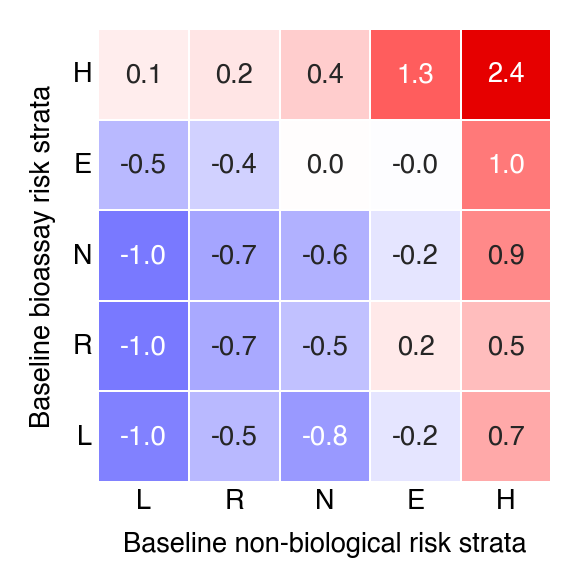

In [153]:
def calc_odds_ratio(data, bio_decile, psycho_decile):
    # Create a 2x2 contingency table
    strata = data[(data['bio_strata'] == bio_decile) & (data['psycho_strata'] == psycho_decile)]
    rest = data[(data['bio_strata'] != bio_decile) | (data['psycho_strata'] != psycho_decile)]
    contingency_table = [[strata['Dev_Dx'].sum(), len(strata) - strata['Dev_Dx'].sum()],
                         [rest['Dev_Dx'].sum(), len(rest) - rest['Dev_Dx'].sum()]]

    # Calculate odds ratio
    odds_ratio, _ = scipy.stats.fisher_exact(contingency_table)
    return odds_ratio

dev_cols = [i[:-3]+'_developed_T0_to_T1' for i in df_full.filter(like='NCI').columns][1:]
df_lng = df_full.merge(UKB[['eid','healthy_T0_and_T1','NumberChronicPainTypes_T1']+dev_cols],on='eid')
df_lng['Dev_Dx'] = np.where(df_lng[dev_cols].sum(axis=1)>0,1,0)
df_dx = df_lng[(df_lng['Dev_Dx'] == 1) | (df_lng['healthy_T0_and_T1'] == 1)]
df_dx = df_dx[df_dx['Dx'] == 0]

mod = 'Blood'
strata = 5

# Logit transform
df_dx[mod], df_dx['Psychosocial'] = np.log(df_dx[mod] / (1 - df_dx[mod])), np.log(df_dx['Psychosocial'] / (1 - df_dx['Psychosocial']))

df_dx['bio_strata'] = pd.qcut(df_dx[mod], q=strata, labels=False)
df_dx['psycho_strata'] = pd.qcut(df_dx['Psychosocial'], q=strata, labels=False)
df_dx['Bio'] = df_dx[mod]
df_dx['Psycho'] = df_dx['Psychosocial']

average_pivot_table = pd.DataFrame({
    i: {j: calc_odds_ratio(df_dx, i, j) for j in range(strata)}
    for i in range(strata)
})

fig, ax = plt.subplots(figsize=(2, 2))
sns.heatmap(np.log(average_pivot_table.T), cmap='seismic', annot=True, fmt=".1f",
        linewidth=.1, center=0, vmin=-2, vmax=4, cbar=False, square=True)
ax.set_title('')
ax.set_xlabel('Baseline non-biological risk strata')
ax.set_ylabel(f'Baseline bioassay risk strata')
ax.invert_yaxis()

ax.set_xticklabels(['L','R','N','E','H'])
ax.set_yticklabels(['L','R','N','E','H'], rotation=0)

plt.tick_params(axis='both', which='both', length=0)
plt.show()

# fig.savefig(f"/Users/Patty/Desktop/Biomarker_Paper/Fig_5_Stratification/{mod}_Lng_OR_Strata.pdf", 
#     dpi=300, transparent=False, bbox_inches='tight')

# Sankey quantile combinations

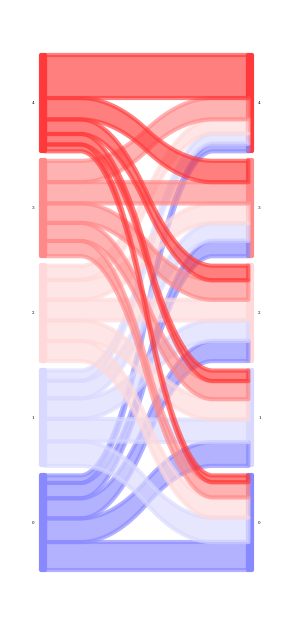

In [99]:
from pySankey.sankey import sankey

df_sankey = df_dx.sort_values(['bio_strata','psycho_strata'])[['bio_strata','psycho_strata']]
labels = df_sankey.bio_strata.unique()
dico_sankey = dict(zip(labels, [mpl.colors.to_hex(c) for c in sns.color_palette('seismic', 20)][5:16]))
dico_sankey = dict(zip(labels, [mpl.colors.to_hex(c) for c in sns.color_palette('seismic', 12)][4:10]))


sankey(left=df_sankey["bio_strata"], right=df_sankey["psycho_strata"], 
        colorDict=dico_sankey,
        aspect=20, fontsize=0)

plt.gcf().set_size_inches((1,2.5))

plt.savefig(f"/Users/Patty/Desktop/Biomarker_Paper/Fig_5_Stratification/Strata_schem.pdf", 
        dpi=300, transparent=False, bbox_inches='tight')